In [18]:
import collections
import math
import os
import time

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# We're assuming 2-D data with a known true mean of (0, 0)
true_mean = np.zeros([2], dtype=np.float32)
# We'll make the 2 coordinates correlated
true_cor = np.array([[1.0, 0.9], [0.9, 1.0]], dtype=np.float32)
# And we'll give the 2 coordinates different variances
true_var = np.array([4.0, 1.0], dtype=np.float32)
# Combine the variances and correlations into a covariance matrix
true_cov = np.expand_dims(np.sqrt(true_var), axis=1).dot(
    np.expand_dims(np.sqrt(true_var), axis=1).T) * true_cor
# We'll be working with precision matrices, so we'll go ahead and compute the
# true precision matrix here
true_precision = np.linalg.inv(true_cov)
print(true_precision)

[[ 1.3157892 -2.3684204]
 [-2.3684204  5.263157 ]]


In [3]:
# Here's our resulting covariance matrix
print(true_cov)
# Verify that it's positive definite, since np.random.multivariate_normal
# complains about it not being positive definite for some reason.
# (Note that I'll be including a lot of sanity checking code in this notebook -
# it's a *huge* help for debugging)
print('eigenvalues: ', np.linalg.eigvals(true_cov))

[[4.  1.8]
 [1.8 1. ]]
eigenvalues:  [4.843075   0.15692513]


[[ 1.9960071   1.371155  ]
 [-0.31086254 -0.8045083 ]
 [ 0.8756285   1.1325209 ]
 [ 4.908268    2.111288  ]
 [-2.3772883  -1.4926063 ]]
(100, 2)


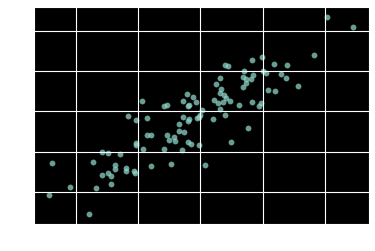

mean of observations: [-0.2400961  -0.16638891]
true mean: [0. 0.]
covariance of observations:
 [[3.95307663 1.68718485]
 [1.68718485 0.9491028 ]]
true covariance:
 [[4.  1.8]
 [1.8 1. ]]


In [4]:
# Set the seed so the results are reproducible.
np.random.seed(123)

# Now generate some observations of our random variable.
# (Note that I'm suppressing a bunch of spurious about the covariance matrix
# not being positive semidefinite via check_valid='ignore' because it really is
# positive definite!)
my_data = np.random.multivariate_normal(
    mean=true_mean, cov=true_cov, size=100,
    check_valid='ignore').astype(np.float32)
print(my_data[:5])
print(my_data.shape)
# Do a scatter plot of the observations to make sure they look like what we
# expect (higher variance on the x-axis, y values strongly correlated with x)
plt.scatter(my_data[:, 0], my_data[:, 1], alpha=0.75)
plt.show()
print('mean of observations:', np.mean(my_data, axis=0))
print('true mean:', true_mean)
print('covariance of observations:\n', np.cov(my_data, rowvar=False))
print('true covariance:\n', true_cov)

In [5]:
def log_lik_data_numpy(precision, data):
  # np.linalg.inv is a really inefficient way to get the covariance matrix, but
  # remember we don't care about speed here
    cov = np.linalg.inv(precision)
    rv = scipy.stats.multivariate_normal(true_mean, cov)
    return np.sum(rv.logpdf(data))

# test case: compute the log likelihood of the data given the true parameters
log_lik_data_numpy(true_precision, my_data)

-280.81821355532696

# Wishart distribution

In [6]:
PRIOR_DF = 3
PRIOR_SCALE = np.eye(2, dtype=np.float32) / PRIOR_DF

def log_lik_prior_numpy(precision):
    rv = scipy.stats.wishart(df=PRIOR_DF, scale=PRIOR_SCALE)
    return rv.logpdf(precision)

# test case: compute the prior for the true parameters
log_lik_prior_numpy(true_precision)

-9.103606346649766

In [7]:
n = my_data.shape[0]
nu_prior = PRIOR_DF
v_prior = PRIOR_SCALE
nu_posterior = nu_prior + n
v_posterior = np.linalg.inv(np.linalg.inv(v_prior) + my_data.T.dot(my_data))
posterior_mean = nu_posterior * v_posterior
v_post_diag = np.expand_dims(np.diag(v_posterior), axis=1)
posterior_sd = np.sqrt(nu_posterior *
                       (v_posterior ** 2.0 + v_post_diag.dot(v_post_diag.T)))

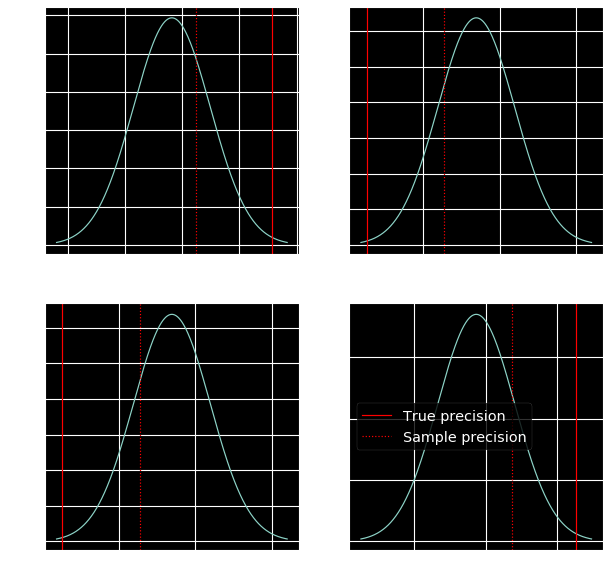

In [8]:
sample_precision = np.linalg.inv(np.cov(my_data, rowvar=False, bias=False))
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        loc = posterior_mean[i, j]
        scale = posterior_sd[i, j]
        xmin = loc - 3.0 * scale
        xmax = loc + 3.0 * scale
        x = np.linspace(xmin, xmax, 1000)
        y = scipy.stats.norm.pdf(x, loc=loc, scale=scale)
        ax.plot(x, y)
        ax.axvline(true_precision[i, j], color='red', label='True precision')
        ax.axvline(sample_precision[i, j], color='red', linestyle=':', label='Sample precision')
ax.set_title('precision[%d, %d]' % (i, j))
plt.legend()
plt.show()

# Tensorflow implementation

In [12]:
with tf.Graph().as_default() as g:
    # case 1: get log probabilities for a vector of iid draws from a single
    # normal distribution
    norm1 = tfd.Normal(loc=0., scale=1.)
    probs1 = norm1.log_prob(tf.constant([1., 0.5, 0.]))

    # case 2: get log probabilities for a vector of independent draws from
    # multiple normal distributions with different parameters.  Note the vector
    # values for loc and scale in the Normal constructor.
    norm2 = tfd.Normal(loc=[0., 2., 4.], scale=[1., 1., 1.])
    probs2 = norm2.log_prob(tf.constant([1., 0.5, 0.]))

    g.finalize()
  
# with tf.Session(graph=g) as sess:
#     print('iid draws from a single normal:', sess.run(probs1))
#     print('draws from a batch of normals:', sess.run(probs2))

In [21]:
def log_lik_data(precisions, replicated_data):
    n = tf.shape(precisions)[0]  # number of precision matrices
    # We're estimating a precision matrix; we have to invert to get log
    # probabilities.  Cholesky inversion should be relatively efficient,
    # but as we'll see later, it's even better if we can avoid doing the Cholesky
    # decomposition altogether.
    precisions_cholesky = tf.compat.v1.cholesky(precisions)
    covariances = tf.compat.v1.cholesky_solve(precisions_cholesky,
                                  tf.eye(2, batch_shape=[n]))
    rv_data = tfd.MultivariateNormalFullCovariance(
      loc=tf.zeros([n, 2]),
      covariance_matrix=covariances,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)

    return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [15]:
# For our test, we'll use a tensor of 2 precision matrices.
# We'll need to replicate our data for the likelihood function.
# Remember, TFP wants the data to be structured so that the sample dimensions
# are first (100 here), then the batch dimensions (2 here because we have 2
# precision matrices), then the event dimensions (2 because we have 2-D
# Gaussian data).  We'll need to add a middle dimension for the batch using
# expand_dims, and then we'll need to create 2 replicates in this new dimension
# using tile.
n = 2
replicated_data = np.tile(np.expand_dims(my_data, axis=1), reps=[1, 2, 1])
print(replicated_data.shape)

(100, 2, 2)


In [22]:
# check against the numpy implementation
with tf.Graph().as_default() as g:
    precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
    n = precisions.shape[0]
    lik_tf = log_lik_data(precisions, replicated_data=replicated_data)
    g.finalize()

with tf.Session(graph=g) as sess:
    lik_tf_ = sess.run(lik_tf)
    for i in range(n):
        print(i)
        print('numpy:', log_lik_data_numpy(precisions[i], my_data))
        print('tensorflow:', lik_tf_[i])

NameError: name 'VALIDATE_ARGS' is not defined